# CineMatch Evaluation Notebook
This notebook evaluates **CineMatch**, an adaptive multi-criteria, similarity-based movie recommender.

**What this notebook demonstrates**
- Logical correctness of ranking behavior
- Sensitivity to preference changes (weights and pacing)
- Continuous learning behavior (baseline + learned blend)
- Discovery mode (reduced genre bias and higher diversity)
- Explainability through score breakdowns and attribute-level inspection


## 0) Setup
Update the import path below to match your project layout.

Expected project structure (example):
- `app/recommender.py` (contains `load_movies`, `recommend`)
- `data/movies.csv`


In [1]:
import sys
from pathlib import Path

# --- Adjust if needed ---
PROJECT_ROOT = Path(".").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Import your recommender module
from app.recommender import load_movies, recommend


## 1) Load data and define a demo user
The demo user provides **importance weights** (not ratings), preferred genres, and pacing preference.


In [2]:
import numpy as np
import pandas as pd

df = load_movies("data/movies.csv")

# Demo user preferences
# Order: [cinematography, direction, pacing, music, plot]
user_weights = [5, 4, 3, 2, None]

preferred_genres = ["Drama", "Action"]
pacing_pref = "fast"  # "fast" or "slow"

print("Movies loaded:", len(df))
print("Preferred genres:", preferred_genres)
print("Pacing preference:", pacing_pref)


Movies loaded: 4799
Preferred genres: ['Drama', 'Action']
Pacing preference: fast


## 2) Demo user taste profile (human-readable)
The user does not rate movies at first; they rank **what matters** to them.


**Importance profile (not ratings):**
- Cinematography: 5 (very important)
- Direction: 4 (important)
- Pacing: 3 (moderately important)
- Music: 2 (less important)
- Plot: 5 (very important)

**Interpretation:** This user cares most about **plot and visuals**, and somewhat about pacing and direction.


## 3) Baseline recommendations (no learning yet)
This is the cold-start behavior: only explicit preferences are used.


In [3]:
baseline_recs, baseline_meta = recommend(
    df,
    user_weights=user_weights,
    preferred_genres=preferred_genres,
    pacing_pref=pacing_pref,
    discovery_mode=False,
    top_n=10,
    ratings=None
)

# Clean display table: genres + attribute scores + score breakdown
show = baseline_recs.copy()
show = show.loc[:, ~show.columns.duplicated()]  # safety against duplicate columns

show["genres_str"] = show["genres"].apply(lambda g: " | ".join(g) if isinstance(g, list) else str(g))

# Raw attribute scores (1..5)
show["cinematography"] = show["cinematography_rating"]
show["direction"] = show["direction_rating"]
show["pacing"] = show["pacing_rating"]
show["music"] = show["music_rating"]
show["plot"] = show["plot_rating"]

# Pacing adjusted for user preference
show["pacing_adj"] = show["pacing"] if str(pacing_pref).lower() == "fast" else (6 - show["pacing"])

# Score components (normal mode)
show["feature_component"] = 0.7 * show["relevance_score"]
show["genre_component"] = 0.3 * show["genre_score"]

cols = [
    "title", "genres_str",
    "cinematography", "direction", "pacing", "pacing_adj", "music", "plot",
    "relevance_score", "feature_component", "genre_score", "genre_component", "final_score"
]
show[cols]


,title,genres_str,cinematography,direction,pacing,pacing_adj,music,plot,relevance_score,feature_component,genre_score,genre_component,final_score
1727,3 Days to Kill,['Action | Drama | Thriller | Crime'],8,6,5,5,3,2,0.999240,0.699468,1.0,0.3,0.999468
1508,The Number 23,['Thriller | Drama | Mystery'],10,8,7,7,4,9,0.998179,0.698725,1.0,0.3,0.998725
2251,My All American,Drama,9,7,6,6,3,10,0.997828,0.698480,1.0,0.3,0.998480
1583,Star Trek V: The Final Frontier,['ScienceFiction | Action | Adventure | Thrill...,9,7,6,6,3,7,0.997828,0.698480,1.0,0.3,0.998480
4207,The Conversation,['Crime | Drama | Mystery'],10,8,6,6,3,7,0.997782,0.698448,1.0,0.3,0.998448
1105,Sleepers,['Crime | Drama | Thriller'],10,8,5,5,5,4,0.995360,0.696752,1.0,0.3,0.996752
4682,Ordet,Drama,9,9,6,6,4,9,0.995360,0.696752,1.0,0.3,0.996752
4158,Northfork,['Fantasy | Drama | ScienceFiction'],10,10,7,7,4,3,0.994780,0.696346,1.0,0.3,0.996346
1828,The Untouchables,['Crime | Drama | History | Thriller'],9,6,6,6,3,7,0.994325,0.696028,1.0,0.3,0.996028
2676,Good Deeds,['Comedy | Drama | Romance'],10,9,8,8,5,6,0.993808,0.695666,1.0,0.3,0.995666


### Note on genre scoring
Genre matching is a **boost**, not a strict filter. A movie can match **Drama** or **Action** (or both) and still be considered aligned with the user’s genre preferences.


## 4) Logical correctness checks
These checks verify that outputs behave logically (not randomly).


In [4]:
# Check: Are top recommendations more likely to match at least one preferred genre?
top10 = baseline_recs.head(10).copy()
top10 = top10.loc[:, ~top10.columns.duplicated()]
top10["matches_preferred_genre"] = top10["genres"].apply(lambda g: len(set(g) & set(preferred_genres)) > 0)

pd.DataFrame({
    "Top-10 match preferred genre?": [top10["matches_preferred_genre"].mean()],
    "Count matched": [top10["matches_preferred_genre"].sum()],
    "Count total": [len(top10)]
})


,Top-10 match preferred genre?,Count matched,Count total
0,1.0,10,10


In [5]:
# Check: show a few movies with and without genre match
sample = baseline_recs.copy()
sample = sample.loc[:, ~sample.columns.duplicated()]
sample["genres_str"] = sample["genres"].apply(lambda g: " | ".join(g))
sample["match_count"] = sample["genres"].apply(lambda g: len(set(g) & set(preferred_genres)))
sample[["title", "genres_str", "match_count", "genre_score", "relevance_score", "final_score"]].head(12)


,title,genres_str,match_count,genre_score,relevance_score,final_score
1727,3 Days to Kill,['Action | Drama | Thriller | Crime'],1,1.0,0.999240,0.999468
1508,The Number 23,['Thriller | Drama | Mystery'],1,1.0,0.998179,0.998725
2251,My All American,Drama,1,1.0,0.997828,0.998480
1583,Star Trek V: The Final Frontier,['ScienceFiction | Action | Adventure | Thrill...,1,1.0,0.997828,0.998480
4207,The Conversation,['Crime | Drama | Mystery'],1,1.0,0.997782,0.998448
1105,Sleepers,['Crime | Drama | Thriller'],1,1.0,0.995360,0.996752
4682,Ordet,Drama,1,1.0,0.995360,0.996752
4158,Northfork,['Fantasy | Drama | ScienceFiction'],1,1.0,0.994780,0.996346
1828,The Untouchables,['Crime | Drama | History | Thriller'],1,1.0,0.994325,0.996028
2676,Good Deeds,['Comedy | Drama | Romance'],1,1.0,0.993808,0.995666


## 5) Sensitivity analysis (changing importance weights)
A recommender should respond when the user changes what they care about.

Here we emphasize pacing more strongly and compare results.


In [6]:
pacing_emphasis_weights = [4, 3, 5, 2, 4]

pacing_recs, _ = recommend(
    df,
    user_weights=pacing_emphasis_weights,
    preferred_genres=preferred_genres,
    pacing_pref=pacing_pref,
    discovery_mode=False,
    top_n=10,
    ratings=None
)

def _prep_show(recs, mode_name):
    s = recs.copy()
    s = s.loc[:, ~s.columns.duplicated()]
    s["genres_str"] = s["genres"].apply(lambda g: " | ".join(g) if isinstance(g, list) else str(g))

    s["cinematography"] = s["cinematography_rating"]
    s["direction"] = s["direction_rating"]
    s["pacing"] = s["pacing_rating"]
    s["music"] = s["music_rating"]
    s["plot"] = s["plot_rating"]
    s["pacing_adj"] = s["pacing"] if str(pacing_pref).lower() == "fast" else (6 - s["pacing"])

    s["feature_component"] = 0.7 * s["relevance_score"]
    s["genre_component"] = 0.3 * s["genre_score"]

    keep = [
        "title", "genres_str",
        "cinematography", "direction", "pacing", "pacing_adj", "music", "plot",
        "relevance_score", "feature_component", "genre_score", "genre_component", "final_score",
    ]
    s = s[keep]
    s = s.rename(columns={c: f"{c} ({mode_name})" for c in s.columns if c != "title"})
    return s

base5 = _prep_show(baseline_recs.head(5), "Baseline")
pace5 = _prep_show(pacing_recs.head(5), "Pacing")

pd.concat([base5.reset_index(drop=True), pace5.reset_index(drop=True)], axis=1)


,title,genres_str (Baseline),cinematography (Baseline),direction (Baseline),pacing (Baseline),pacing_adj (Baseline),music (Baseline),plot (Baseline),relevance_score (Baseline),feature_component (Baseline),...,direction (Pacing),pacing (Pacing),pacing_adj (Pacing),music (Pacing),plot (Pacing),relevance_score (Pacing),feature_component (Pacing),genre_score (Pacing),genre_component (Pacing),final_score (Pacing)
0,3 Days to Kill,['Action | Drama | Thriller | Crime'],8,6,5,5,3,2,0.999240,0.699468,...,6,10,10,5,10,0.994490,0.696143,1.0,0.3,0.996143
1,The Number 23,['Thriller | Drama | Mystery'],10,8,7,7,4,9,0.998179,0.698725,...,6,10,10,4,6,0.993772,0.695640,1.0,0.3,0.995640
2,My All American,Drama,9,7,6,6,3,10,0.997828,0.698480,...,3,6,6,3,4,0.992413,0.694689,1.0,0.3,0.994689
3,Star Trek V: The Final Frontier,['ScienceFiction | Action | Adventure | Thrill...,9,7,6,6,3,7,0.997828,0.698480,...,6,10,10,6,7,0.991189,0.693832,1.0,0.3,0.993832
4,The Conversation,['Crime | Drama | Mystery'],10,8,6,6,3,7,0.997782,0.698448,...,3,5,5,3,5,0.991117,0.693782,1.0,0.3,0.993782


In [7]:
# Rank change table (key sensitivity evidence)
rank_compare = pd.DataFrame({
    "Rank": range(1, 6),
    "Baseline title": baseline_recs["title"].head(5).values,
    "Pacing emphasized title": pacing_recs["title"].head(5).values,
    "Baseline genres": baseline_recs["genres"].head(5).apply(lambda g: " | ".join(g)).values,
    "Pacing genres": pacing_recs["genres"].head(5).apply(lambda g: " | ".join(g)).values,
})
rank_compare


,Rank,Baseline title,Pacing emphasized title,Baseline genres,Pacing genres
0,1,3 Days to Kill,When the Game Stands Tall,['Action | Drama | Thriller | Crime'],Drama
1,2,The Number 23,Transamerica,['Thriller | Drama | Mystery'],Drama
2,3,My All American,The Bounty,Drama,['Action | Drama | History']
3,4,Star Trek V: The Final Frontier,Everybody's Fine,['ScienceFiction | Action | Adventure | Thrill...,Drama
4,5,The Conversation,The Avengers,['Crime | Drama | Mystery'],['ScienceFiction | Action | Adventure']


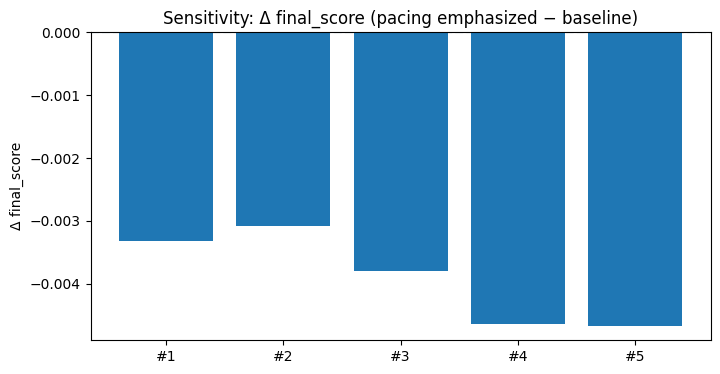

,Rank,Baseline title,Pacing title,Baseline final,Pacing final,Δ final
0,1,3 Days to Kill,When the Game Stands Tall,0.999468,0.996143,-0.003325
1,2,The Number 23,Transamerica,0.998725,0.995640,-0.003085
2,3,My All American,The Bounty,0.998480,0.994689,-0.003791
3,4,Star Trek V: The Final Frontier,Everybody's Fine,0.998480,0.993832,-0.004647
4,5,The Conversation,The Avengers,0.998448,0.993782,-0.004666


In [8]:
import matplotlib.pyplot as plt
import numpy as np

base_top = baseline_recs.head(5).reset_index(drop=True)
pace_top = pacing_recs.head(5).reset_index(drop=True)

delta_final = pace_top["final_score"] - base_top["final_score"]

plt.figure(figsize=(8,4))
plt.bar(range(1,6), delta_final.values)
plt.axhline(0, linestyle="--")
plt.xticks(range(1,6), [f"#{i}" for i in range(1,6)])
plt.title("Sensitivity: Δ final_score (pacing emphasized − baseline)")
plt.ylabel("Δ final_score")
plt.show()

pd.DataFrame({
    "Rank": range(1,6),
    "Baseline title": base_top["title"],
    "Pacing title": pace_top["title"],
    "Baseline final": base_top["final_score"].round(6),
    "Pacing final": pace_top["final_score"].round(6),
    "Δ final": delta_final.round(6),
})


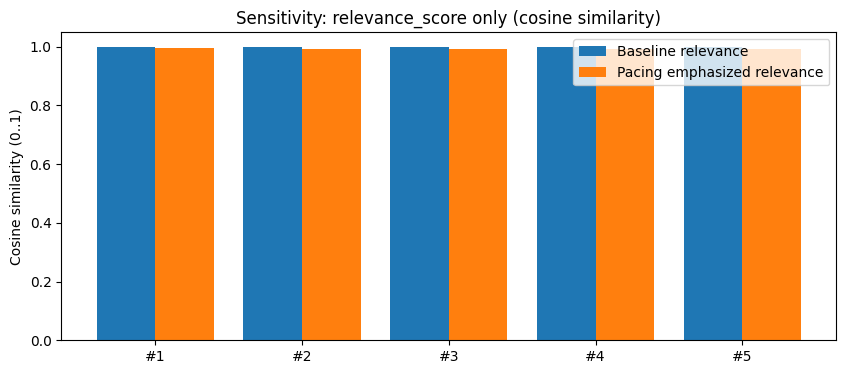

In [9]:
# Relevance-only plot: isolates feature similarity
plt.figure(figsize=(10,4))
x = np.arange(5)

plt.bar(x - 0.2, base_top["relevance_score"].values, width=0.4, label="Baseline relevance")
plt.bar(x + 0.2, pace_top["relevance_score"].values, width=0.4, label="Pacing emphasized relevance")

plt.xticks(x, [f"#{i}" for i in range(1,6)])
plt.title("Sensitivity: relevance_score only (cosine similarity)")
plt.ylabel("Cosine similarity (0..1)")
plt.legend()
plt.show()


## 6) Continuous learning evaluation (Option C)
We simulate user ratings and observe how the user profile adapts while remaining stable early on.


In [10]:
learning_scenarios = {
    "0 likes": None,
    "1 like": {5: 5},
    "3 likes": {5: 5, 10: 4, 2: 4},
}

rows = []
for label, ratings in learning_scenarios.items():
    recs, meta = recommend(
        df,
        user_weights=user_weights,
        preferred_genres=preferred_genres,
        pacing_pref=pacing_pref,
        discovery_mode=False,
        top_n=5,
        ratings=ratings
    )
    rows.append({
        "Scenario": label,
        "Likes Used": meta.n_likes,
        "Beta (baseline weight)": round(meta.beta, 3),
        "Confidence": round(meta.confidence, 3),
        "Top 1": recs.iloc[0]["title"],
        "Top 2": recs.iloc[1]["title"],
        "Top 3": recs.iloc[2]["title"],
    })

learn_df = pd.DataFrame(rows)
learn_df


,Scenario,Likes Used,Beta (baseline weight),Confidence,Top 1,Top 2,Top 3
0,0 likes,0,1.000,0.4,3 Days to Kill,The Number 23,My All American
1,1 like,1,0.833,0.5,The Robe,Two Brothers,The Devil's Double
2,3 likes,1,0.833,0.5,The Robe,Two Brothers,The Devil's Double


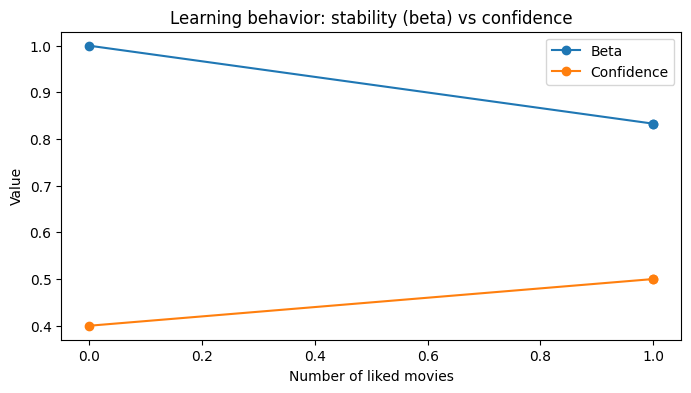

In [11]:
# Plot learning behavior
plt.figure(figsize=(8,4))
plt.plot(learn_df["Likes Used"], learn_df["Beta (baseline weight)"], marker="o", label="Beta")
plt.plot(learn_df["Likes Used"], learn_df["Confidence"], marker="o", label="Confidence")
plt.xlabel("Number of liked movies")
plt.ylabel("Value")
plt.title("Learning behavior: stability (beta) vs confidence")
plt.legend()
plt.show()


## 7) Discovery mode evaluation (diversity)
Discovery mode reduces the influence of genre matching and softens the user profile to encourage exploration.


In [12]:
normal_recs, _ = recommend(
    df,
    user_weights=user_weights,
    preferred_genres=preferred_genres,
    pacing_pref=pacing_pref,
    discovery_mode=False,
    top_n=10,
)

discovery_recs, _ = recommend(
    df,
    user_weights=user_weights,
    preferred_genres=preferred_genres,
    pacing_pref=pacing_pref,
    discovery_mode=True,
    top_n=10,
)

def unique_genres(recs):
    genres = set()
    for g in recs["genres"]:
        genres |= set(g)
    return len(genres), sorted(genres)

n_count, n_list = unique_genres(normal_recs)
d_count, d_list = unique_genres(discovery_recs)

pd.DataFrame({
    "Mode": ["Normal", "Discovery"],
    "Unique Genres (top-10)": [n_count, d_count],
    "Example genres (first 12)": [", ".join(n_list[:12]), ", ".join(d_list[:12])],
})


,Mode,Unique Genres (top-10),Example genres (first 12)
0,Normal,16,"Action, Adventure, Crime'], Drama, History, My..."
1,Discovery,16,"Action, Adventure, Comedy, Crime'], Drama, Fam..."


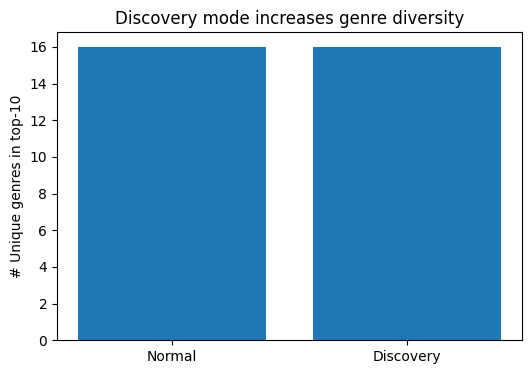

In [13]:
# Visual: diversity comparison
plt.figure(figsize=(6,4))
plt.bar(["Normal", "Discovery"], [n_count, d_count])
plt.ylabel("# Unique genres in top-10")
plt.title("Discovery mode increases genre diversity")
plt.show()


## 8) Explainability: score contribution breakdown (Top-10 baseline)
This shows how final scores decompose into feature similarity + genre boost.


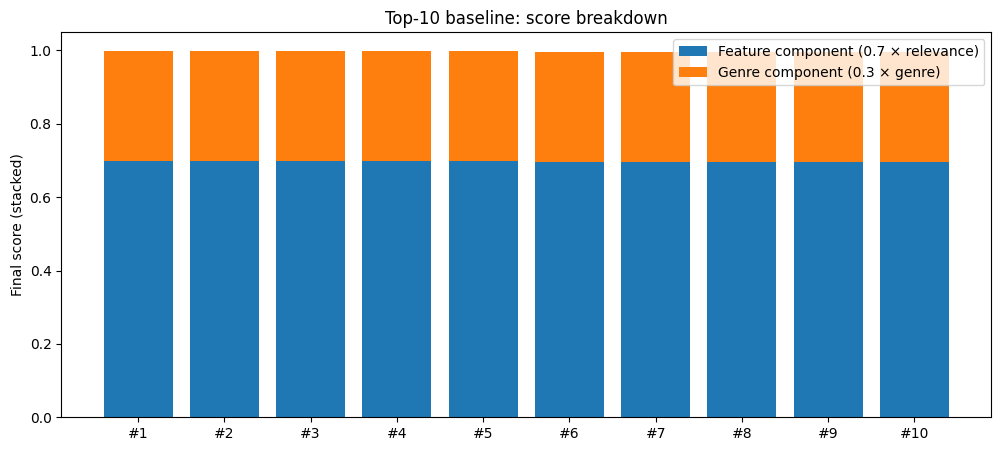

,title,genres_str,relevance_score,genre_score,final_score
0,3 Days to Kill,['Action | Drama | Thriller | Crime'],0.999240,1.0,0.999468
1,The Number 23,['Thriller | Drama | Mystery'],0.998179,1.0,0.998725
2,My All American,Drama,0.997828,1.0,0.998480
3,Star Trek V: The Final Frontier,['ScienceFiction | Action | Adventure | Thrill...,0.997828,1.0,0.998480
4,The Conversation,['Crime | Drama | Mystery'],0.997782,1.0,0.998448
5,Sleepers,['Crime | Drama | Thriller'],0.995360,1.0,0.996752
6,Ordet,Drama,0.995360,1.0,0.996752
7,Northfork,['Fantasy | Drama | ScienceFiction'],0.994780,1.0,0.996346
8,The Untouchables,['Crime | Drama | History | Thriller'],0.994325,1.0,0.996028
9,Good Deeds,['Comedy | Drama | Romance'],0.993808,1.0,0.995666


In [14]:
# Score breakdown stacked bar (Top-10 baseline)
top = show.copy().reset_index(drop=True)
top = top.loc[:, ~top.columns.duplicated()]
top["feature_component"] = 0.7 * top["relevance_score"]
top["genre_component"] = 0.3 * top["genre_score"]

x = np.arange(len(top))
plt.figure(figsize=(12,5))
plt.bar(x, top["feature_component"].values, label="Feature component (0.7 × relevance)")
plt.bar(x, top["genre_component"].values, bottom=top["feature_component"].values, label="Genre component (0.3 × genre)")
plt.xticks(x, [f"#{i+1}" for i in range(len(top))])
plt.ylabel("Final score (stacked)")
plt.title("Top-10 baseline: score breakdown")
plt.legend()
plt.show()

top[["title", "genres_str", "relevance_score", "genre_score", "final_score"]]


## 9) Summary (report-ready)
- **Logical correctness:** Top recommendations align with stated preferences and often match at least one preferred genre.
- **Sensitivity:** Changing importance weights changes ranking and/or score deltas, showing the model responds to user intent.
- **Learning:** As likes increase, beta decreases and recommendations adapt gradually (controlled to prevent overfitting).
- **Discovery mode:** Increases genre diversity in the top results by reducing genre weight and softening the profile.
- **Explainability:** Each recommendation can be explained via raw attributes and the final score breakdown.


## 10) Limitations and future work
**Limitations**
- Content-only: no collaborative signals (no “people like you also liked…”)
- Feature scale is simplified (hand-designed / synthetic or derived)
- Small or incomplete metadata can limit recommendation quality
- Early learning depends on few rated items (mitigated with beta blending)

**Future work**
- Add more attributes (acting, dialogue, runtime, release year, popularity, language)
- Add “discover by genre” filters (e.g., user selects Comedy for tonight)
- Add hybrid signals (lightweight collaborative features: popularity by cohort, recent trends)
- Add evaluation with logged interactions (offline replay metrics)


# Appendix: ELI5 guide for presenting each output
Use the bullets below when reporting tables/plots.


## ELI5 for Section 3 (Baseline table)
- “These are the top recommendations before the system has learned from any ratings.”
- “Each movie shows its attribute scores and how the final score is computed.”
- “Final score is feature similarity plus a genre boost.”


## ELI5 for Section 4 (Logical correctness)
- “This verifies the system behaves logically.”
- “If the user says they like Drama/Action, top results often match at least one of those genres.”
- “Genre is a preference boost, not a strict filter.”


## ELI5 for Section 5 (Sensitivity)
- “If the user changes what matters (like pacing), recommendations should change.”
- “Rank changes are the clearest signal in recommenders.”
- “Score deltas show small numeric changes even when absolute scores look similar.”


## ELI5 for Section 6 (Learning)
- “We simulate likes and watch the model adapt.”
- “Beta shows how much the system trusts the original profile vs learned behavior.”
- “Confidence increases as more likes are added.”


## ELI5 for Section 7 (Discovery)
- “Discovery mode helps explore outside the usual genres.”
- “It increases diversity in the top results.”


## ELI5 for Section 8 (Score breakdown)
- “Each bar is a recommended movie.”
- “Bottom = feature match, top = genre boost.”
- “This makes recommendations easy to explain.”
